## Imports

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import mne
from scipy.integrate import trapezoid
import pandas as pd
from scipy.stats import ttest_rel

## Defining Important Features

In [55]:
DATASET_PATH = './data/'  # Update if needed
SUBJECTS = ["S001", "S002", "S003", "S004", "S006","S007", "S008", "S009", "S010","S011", "S012", "S013", "S014", "S015", "S020","S021", "S022", "S023", "S024", "S025", "S075", "S076", "S077", "S078", "S079", "S080"]  

REAL_MOVEMENT_RUNS = ["R03", "R04", "R05", "R07", "R09", "R13"]  
IMAGINED_MOVEMENT_RUNS = ["R06", "R08", "R10", "R11", "R12", "R14"]  
PROCESSED_CHANNELS = ['C3..', 'Cz..', 'C4..']  
SFREQ = 160  
LOW_CUT = 1  
HIGH_CUT = 40  
NOTCH_FREQ = 60  

bands = {
    'theta': (4, 7),
    'alpha': (8, 13),
    'beta': (14, 30),
    'gamma': (30, 40)
}

## Processing

In [56]:
results = {
    'real_movement': {'raw': {}, 'processed': {}},
    'imagined_movement': {'raw': {}, 'processed': {}}
}

In [57]:
for subject in SUBJECTS:
    print(f"Processing subject {subject}...")

    for movement_type, runs in zip(['real_movement', 'imagined_movement'], 
                                   [REAL_MOVEMENT_RUNS, IMAGINED_MOVEMENT_RUNS]):
        for run in runs:
            edf_file = os.path.join(DATASET_PATH, subject, f"{subject}{run}.edf")

            try:
                raw = mne.io.read_raw_edf(edf_file, preload=True)
                raw.pick(PROCESSED_CHANNELS)  
                
                results[movement_type]['raw'].setdefault(subject, {})[run] = {
                    ch: raw.get_data(picks=[ch])[0] for ch in PROCESSED_CHANNELS
                }
                
                raw.notch_filter(NOTCH_FREQ, fir_design='firwin')
                raw.filter(l_freq=LOW_CUT, h_freq=HIGH_CUT, method='fir', fir_design='firwin')

                processed_data = {ch: {} for ch in PROCESSED_CHANNELS}
                
                for ch in PROCESSED_CHANNELS:
                    signal = raw.get_data(picks=[ch])[0]
                    freqs, psd = welch(signal, fs=SFREQ, nperseg=min(len(signal) // 2, 128))

                    for band_name, (fmin, fmax) in bands.items():
                        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
                        processed_data[ch][band_name] = trapezoid(psd[idx], freqs[idx]) if np.any(idx) else 0.0
                    
                    processed_data[ch]['freqs'] = freqs
                    processed_data[ch]['psd'] = psd
                
                results[movement_type]['processed'].setdefault(subject, {})[run] = processed_data
            
            except Exception as e:
                print(f"Error processing {subject} {run}: {e}")

Processing subject S001...
Extracting EDF parameters from C:\Users\Gary Gao\Downloads\data\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass f

### Structuring into dataframe

In [58]:
rows = []

for movement_type in ['real_movement', 'imagined_movement']:
    for subject, runs in results[movement_type]['processed'].items():
        for run, channels in runs.items():
            for ch, features in channels.items():
                row = {
                    'movement_type': movement_type.replace('_movement', ''),
                    'subject': subject,
                    'run': run,
                    'channel': ch
                }
                row.update({band: features[band] for band in bands.keys()})
                rows.append(row)

df = pd.DataFrame(rows)
df.to_csv('processed_band_powers.csv', index=False)

## Visualizations

In [59]:
def plot_avg_psd(channel="C3.."):
    """Plot average PSD across all subjects and trials for real vs. imagined movement,
    with error bands showing variability across subjects."""
    
    real_subject_psds = []
    imagined_subject_psds = []
    
    for subject in SUBJECTS:
        subject_real_run_psds = []
        subject_imagined_run_psds = []
        
        if subject in results['real_movement']['processed']:
            for run in REAL_MOVEMENT_RUNS:
                if run in results['real_movement']['processed'][subject]:
                    if channel in results['real_movement']['processed'][subject][run]:
                        subject_real_run_psds.append(
                            results['real_movement']['processed'][subject][run][channel]['psd']
                        )
        if subject in results['imagined_movement']['processed']:
            for run in IMAGINED_MOVEMENT_RUNS:
                if run in results['imagined_movement']['processed'][subject]:
                    if channel in results['imagined_movement']['processed'][subject][run]:
                        subject_imagined_run_psds.append(
                            results['imagined_movement']['processed'][subject][run][channel]['psd']
                        )
        
        if subject_real_run_psds:
            real_subject_psds.append(np.mean(subject_real_run_psds, axis=0))
        if subject_imagined_run_psds:
            imagined_subject_psds.append(np.mean(subject_imagined_run_psds, axis=0))
    
    real_subject_psds = np.array(real_subject_psds)
    imagined_subject_psds = np.array(imagined_subject_psds)
    
    mean_real_psd = np.mean(real_subject_psds, axis=0)
    sem_real_psd = np.std(real_subject_psds, axis=0) / np.sqrt(real_subject_psds.shape[0])
    
    mean_imag_psd = np.mean(imagined_subject_psds, axis=0)
    sem_imag_psd = np.std(imagined_subject_psds, axis=0) / np.sqrt(imagined_subject_psds.shape[0])
    
    freqs = results['real_movement']['processed'][SUBJECTS[0]][REAL_MOVEMENT_RUNS[0]][channel]['freqs']
    
    # Plot the averaged PSDs with shaded error bands
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mean_real_psd, label="Real Movement - Avg", color="blue")
    plt.fill_between(freqs, mean_real_psd - sem_real_psd, mean_real_psd + sem_real_psd, 
                     color="blue", alpha=0.3)
    
    plt.plot(freqs, mean_imag_psd, label="Imagined Movement - Avg", color="red")
    plt.fill_between(freqs, mean_imag_psd - sem_imag_psd, mean_imag_psd + sem_imag_psd, 
                     color="red", alpha=0.3)
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (µV²/Hz)")
    plt.title(f"Average PSD Across Subjects & Trials - {channel}")
    plt.legend()
    plt.grid(True)
    plt.xlim(LOW_CUT, HIGH_CUT)
    plt.savefig(f'avg_psd_{channel}.png', dpi=300)
    plt.show()

Plotting real_movement for S001 R03 C3..
Plotting imagined_movement for S001 R06 C3..


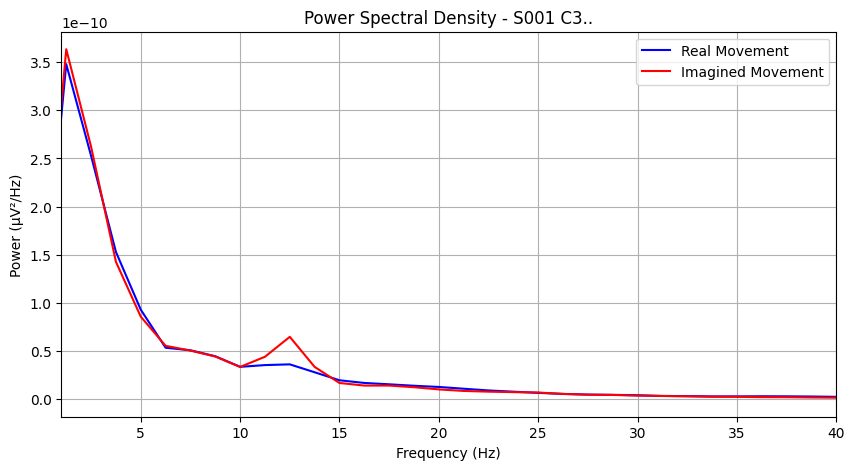

<Figure size 1000x500 with 0 Axes>

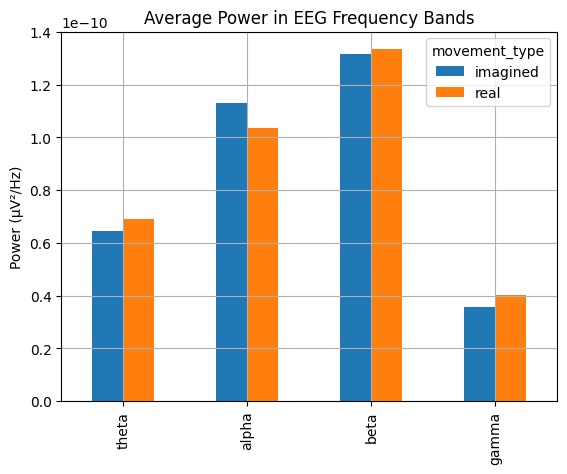

In [60]:
# Plot example PSD
plot_psd(subject="S001", channel="C3..")

# Plot band power distribution
plot_band_powers()

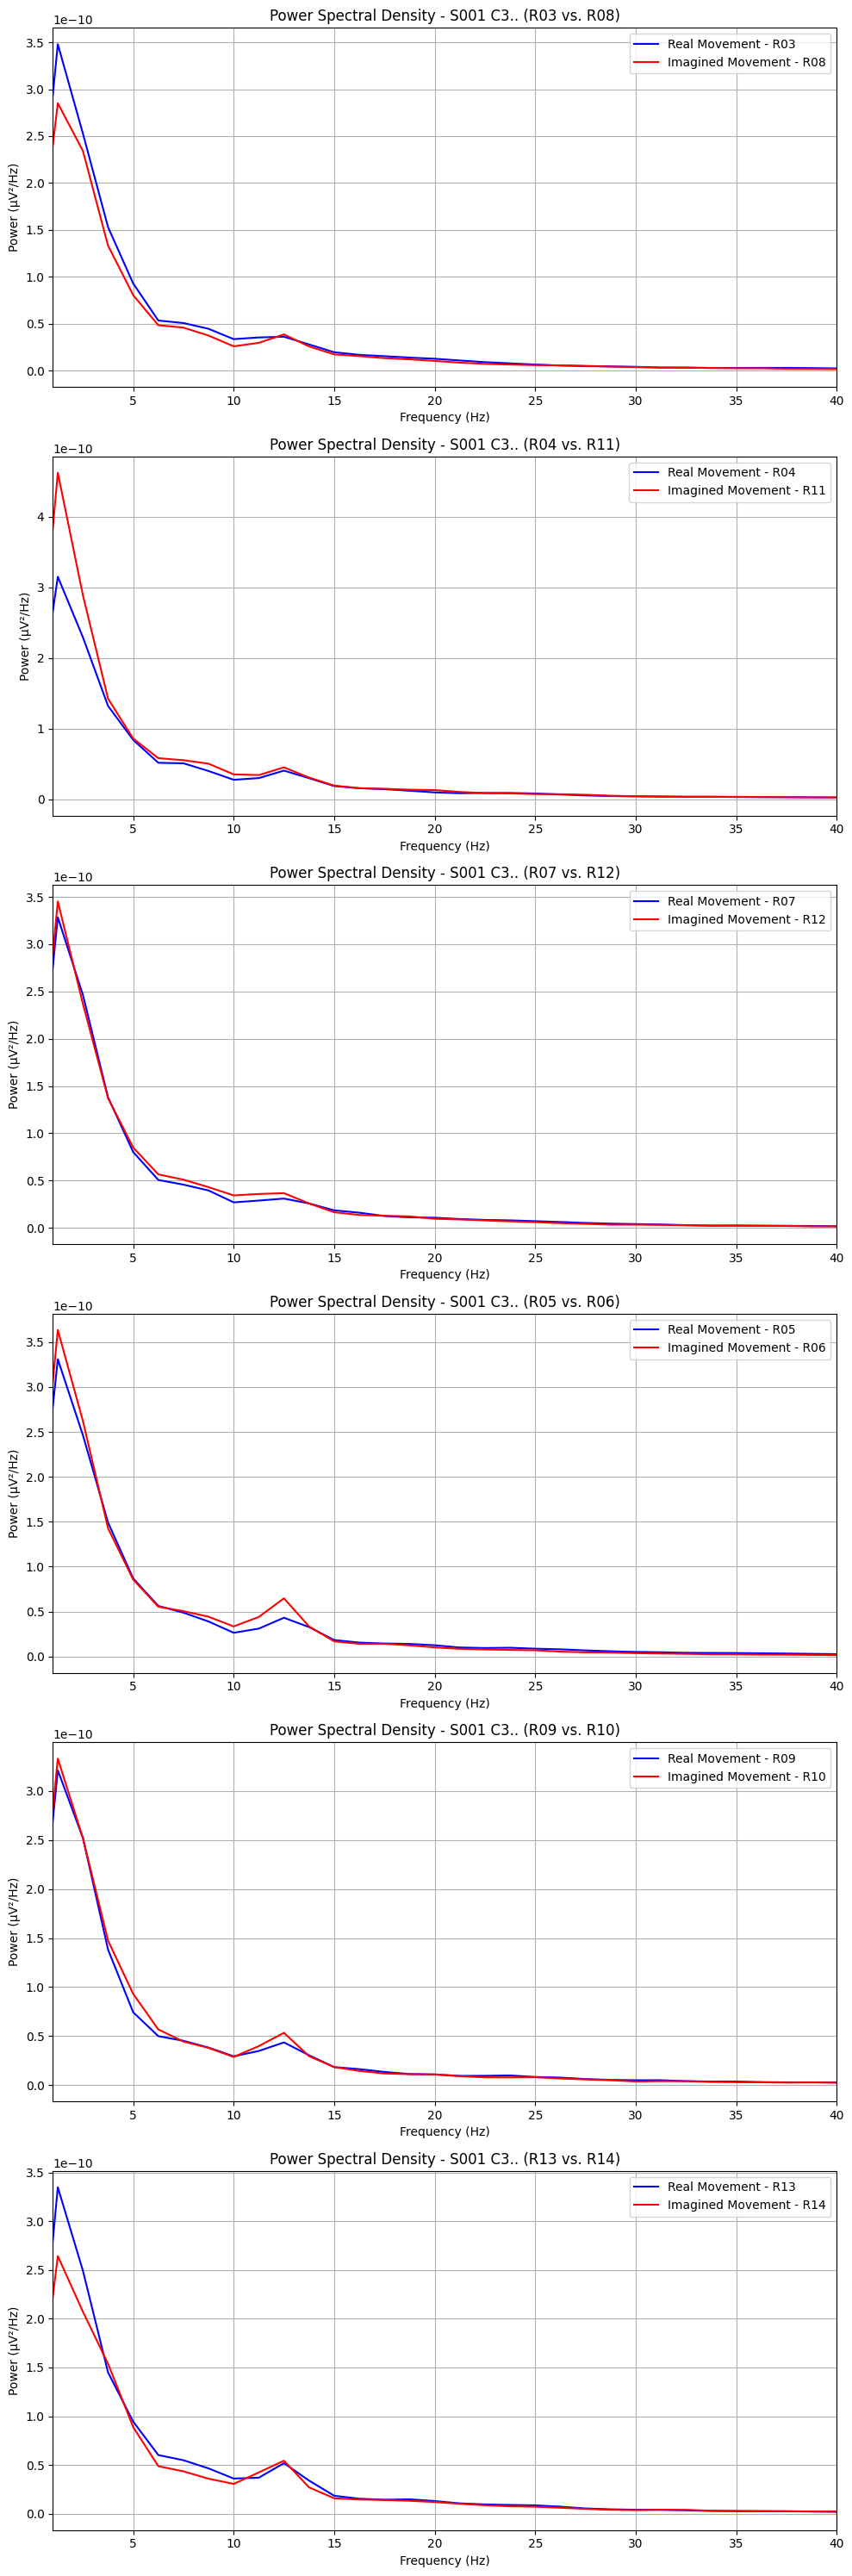

In [61]:
plot_psd_per_pair(subject="S001", channel="C3..")


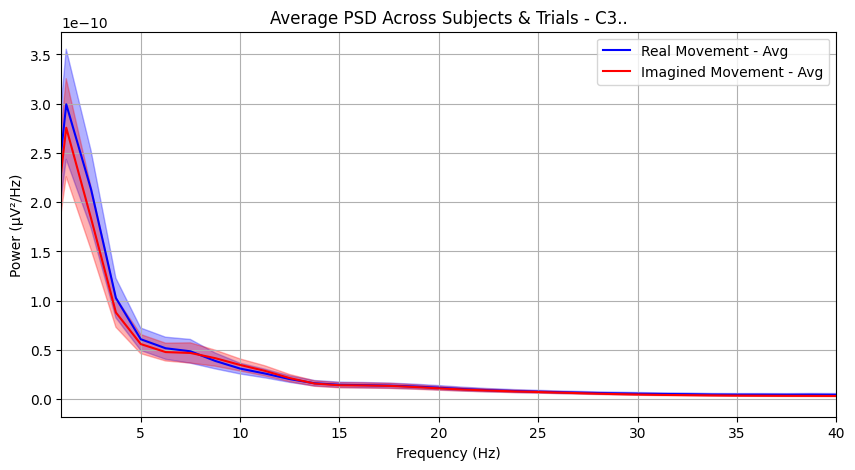

In [62]:
plot_avg_psd()

In [63]:
def perform_t_test(channel='C3..', band='alpha'):
    """Perform a paired t-test between real and imagined movements for the specified frequency band."""
    
    real_band_powers = []
    imagined_band_powers = []

    for subject in SUBJECTS:
        # Ensure the subject has data for both conditions
        if (subject in results['real_movement']['processed'] and 
            subject in results['imagined_movement']['processed']):
            
            real_values = []
            imagined_values = []
            
            # Collect real movement data for the subject
            for run in REAL_MOVEMENT_RUNS:
                if (run in results['real_movement']['processed'][subject] and 
                    channel in results['real_movement']['processed'][subject][run]):
                    real_values.append(results['real_movement']['processed'][subject][run][channel][band])
            
            # Collect imagined movement data for the subject
            for run in IMAGINED_MOVEMENT_RUNS:
                if (run in results['imagined_movement']['processed'][subject] and 
                    channel in results['imagined_movement']['processed'][subject][run]):
                    imagined_values.append(results['imagined_movement']['processed'][subject][run][channel][band])
            
            # Only include subjects with data in both conditions
            if real_values and imagined_values:
                # Average across runs so each subject contributes one value per condition
                real_band_powers.append(np.mean(real_values))
                imagined_band_powers.append(np.mean(imagined_values))

    # Convert lists to arrays
    real_band_powers = np.array(real_band_powers)
    imagined_band_powers = np.array(imagined_band_powers)

    # Check if arrays have equal length before t-test
    if len(real_band_powers) != len(imagined_band_powers):
        raise ValueError("The paired arrays must have the same length. Check your data pairing.")
    
    # Perform a paired t-test
    t_stat, p_value = ttest_rel(real_band_powers, imagined_band_powers)
    
    print(f"Paired T-test results for {band} band in {channel}:")
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.3f}")
    
    # Interpret the results
    if p_value < 0.05:
        print("The difference between real and imagined movement is statistically significant.")
    else:
        print("The difference between real and imagined movement is not statistically significant.")

perform_t_test(channel='C3..', band='alpha')

Paired T-test results for alpha band in C3..:
T-statistic: -2.091
P-value: 0.047
The difference between real and imagined movement is statistically significant.
